# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

## Correlations: Survey Question Responses

Number of students has the highest correlation with sat score (N_s, and N_p). Also, safety scores are highly correlated with sat scores as is evident from the correlation values of the variables saf_s_11 and saf_t_11

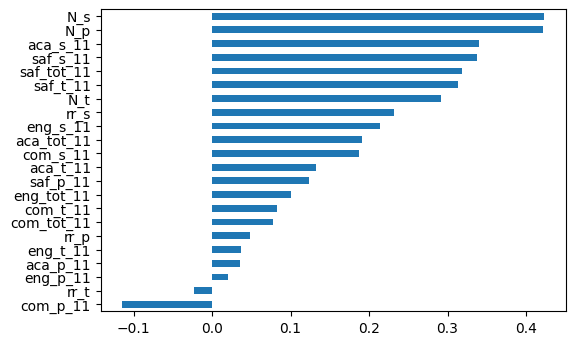

In [11]:
%matplotlib inline

correlations[survey_fields].sort_values().plot.barh()

Here, we dig deeper into the relationship we have observed above - safety scores are highly correlated with sat scores. The figure below further proves that

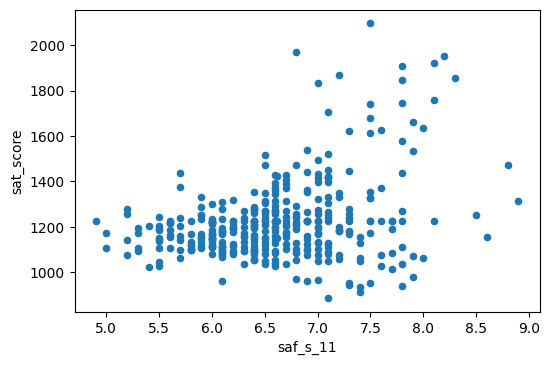

In [12]:
combined.plot.scatter(x='saf_s_11', y='sat_score')

In [13]:
mean_safety = combined.groupby('DBN')['saf_s_11'].mean()
mean_safety.sort_values(ascending=False)

DBN
32K554    8.9
26Q430    8.8
12X278    8.6
12X267    8.5
01M696    8.3
         ... 
05M369    5.2
11X270    5.2
26Q435    5.0
27Q400    5.0
16K688    4.9
Name: saf_s_11, Length: 362, dtype: float64

## Correlations: Race

Here, we try to see whether there are any correlation between race and sat score. First, we see there is a relatively high positive correlation between the percentage of white and asian students and sat score. On the other hand, the proportion of hispanic and black people are associated with lower sat scores

In [14]:
race_correlations = combined[
    ['white_per',
     'asian_per',
     'black_per',
     'hispanic_per',
     'sat_score']].corr()['sat_score']

print(race_correlations)

white_per       0.620718
asian_per       0.570730
black_per      -0.284139
hispanic_per   -0.396985
sat_score       1.000000
Name: sat_score, dtype: float64


We plot the proportion of hispanic people in school versus the sat score here to gain a deeper understanding of the finding above where hispanic people had the biggest negatice correlation with sat score. The plot here shows that indeed that is the case

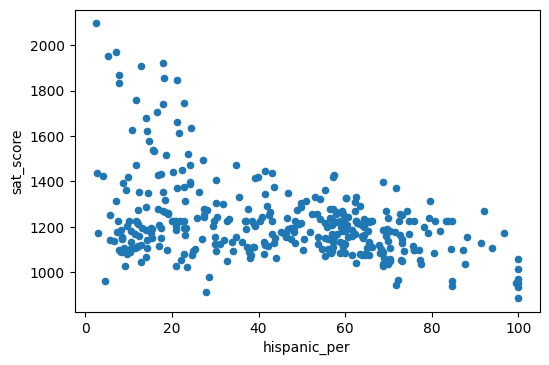

In [15]:
combined.plot.scatter(x='hispanic_per', y='sat_score')

Examine schools with over 95% hispanic students

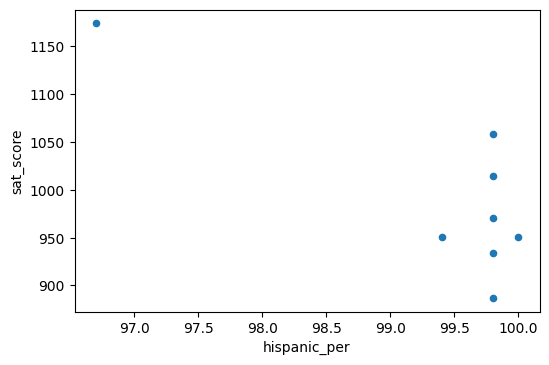

In [16]:
hispanic_95 = combined[combined['hispanic_per'] > 95]
hispanic_95.plot.scatter(x='hispanic_per', y='sat_score')

In [17]:
hispanic_95['SCHOOL NAME'].unique

<bound method Series.unique of 44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object>

The best performing schools had similar characteristics in terms of the number of people who applied. We see that they generally got tens of thousands of applications and only accepted a few hundred. Assuming all races are well-represented - that is, the proportion of races amongst applicants mirror that of the general population, then we expect the proportion of hispanics in such schools to be low

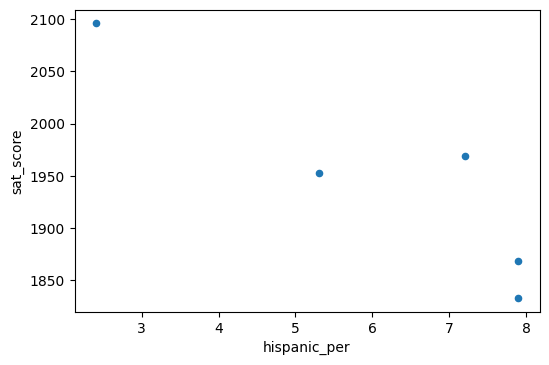

In [18]:
hispanic_mask = combined['hispanic_per'] < 10
sat_score_mask = combined['sat_score'] > 1800

hispanic_10 = combined[hispanic_mask & sat_score_mask]
hispanic_10.plot.scatter(x='hispanic_per', y='sat_score')

In [19]:
hispanic_10['SCHOOL NAME'].unique

<bound method Series.unique of 37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object>

## Correlations: Gender

Male proportion is negatively correlated with sat score, while female proportion is positively correlated with it. This indicates that female generally perform better than their male counterparts

In [23]:
gender_correlations = combined[
    ['male_per',
     'female_per', 'sat_score']].corr()['sat_score']

print(gender_correlations)

male_per     -0.112062
female_per    0.112108
sat_score     1.000000
Name: sat_score, dtype: float64


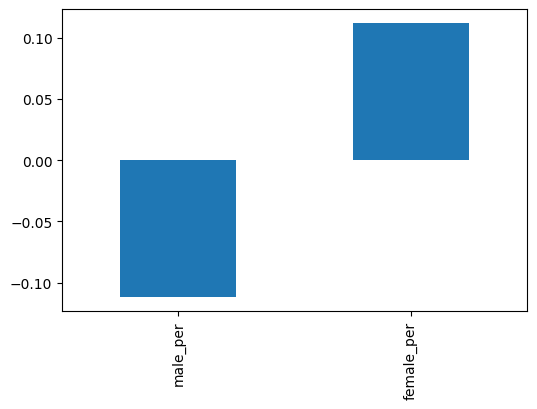

In [26]:
gender_correlations[['male_per', 'female_per']].plot.bar()

We dig deeper into the results obtained above to understand the relationship between gender and sat score. Here, I first make a scatterplot from where we can see that the proportion of female is generally between 40 and 60. That is expected. What's interesting is that the average sat score among schools with over 60% female population is relatively higher than that with less than 40%. This reinforces the finding above where we identified a positive correlation between female proportion in the school and sat score

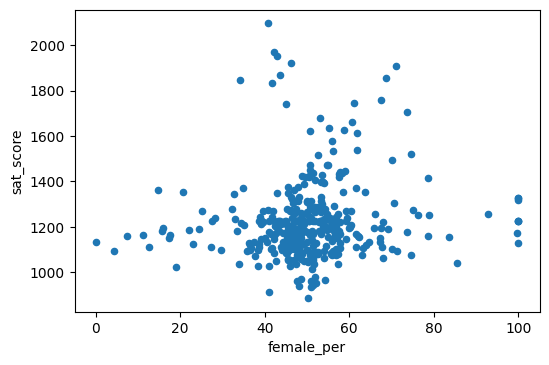

In [28]:
combined.plot.scatter(x='female_per', y='sat_score')

The best performing schools with predominantly female students have typical characteristics of high performing schools including competitive entry. Schools such as FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & ART AND PERFORMING ARTS receive thousand of applications and only end up accepting a few hundred

In [40]:
female_mask = combined['female_per'] > 60
sat_score_mask = combined['sat_score'] > 1700

schools = combined[female_mask & sat_score_mask]
schools['SCHOOL NAME'].unique()

array(['BARD HIGH SCHOOL EARLY COLLEGE', 'ELEANOR ROOSEVELT HIGH SCHOOL',
       'BEACON HIGH SCHOOL',
       'FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & ART AND PERFORMING ARTS',
       'TOWNSEND HARRIS HIGH SCHOOL'], dtype=object)

## Correlations: AP Test Takers

The correlation between percentage test takers and sat score is very small

In [44]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']

combined[['ap_per', 'sat_score']].corr()['sat_score']

ap_per       0.057171
sat_score    1.000000
Name: sat_score, dtype: float64

Upon further exploration on the small correlation, we see an interesting relationship. It seems there is a relationship but the relationship is not linear. High percentage of test takers is associated with high and low sat score, while low percentage ap test taken is associated with middling sat scores

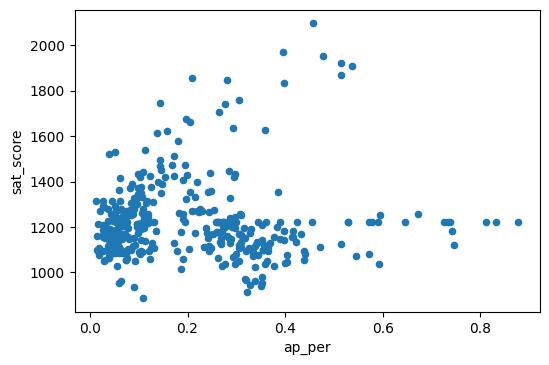

In [45]:
combined.plot.scatter(x='ap_per', y='sat_score')